<a href="https://colab.research.google.com/github/asavari381/Netflix-Stock-Price-Prediction/blob/main/LSTMmodel_NFLX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from scipy.stats import spearmanr
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow import keras
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

[*********************100%***********************]  1 of 1 completed


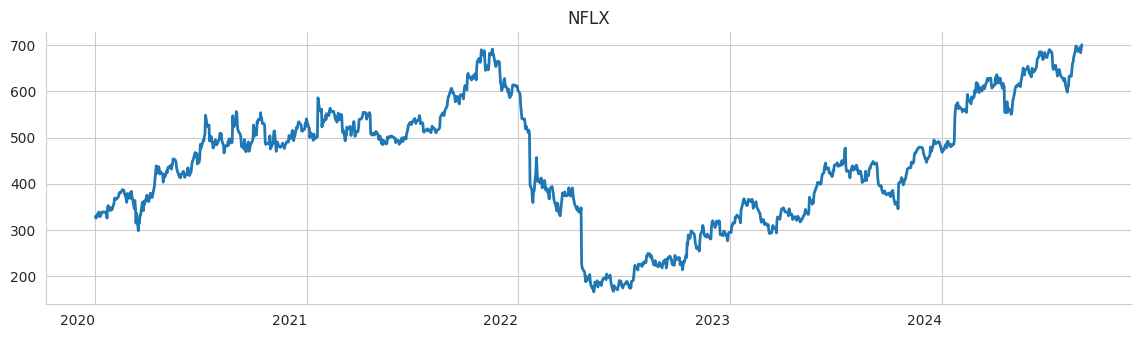

In [ ]:
# set up the random state
sns.set_style('whitegrid')
np.random.seed(42)

start_date = datetime(2020,1,1)
end_date = datetime(2024,8,31)
stock_symbol = 'NFLX'

# Download stock data from yahoo finance
stocks = yf.download('NFLX',start_date ,end_date)
price_type = 'Adj Close'
stock_price = pd.DataFrame(stocks[price_type])

ax = stock_price.plot(title = stock_symbol, legend=False, linewidth = 2, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [ ]:
scaler = MinMaxScaler()
stocks_scaled = pd.Series(scaler.fit_transform(stock_price.values.reshape(-1, 1)).squeeze(),
                         index = stock_price.index)

In [ ]:
def create_lstm_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

window_size = 60
X, y = create_lstm_data(stocks_scaled, window_size = window_size)

# Train-test split
X_train = X[:'2022'].values.reshape(-1, window_size, 1)
y_train = y[:'2022']
y_train.shape

n_obs, window_size, n_features = X_train.shape
# keep the last year for testing
X_test = X['2023':].values.reshape(-1, window_size, 1)
y_test = y['2023':]

In [ ]:
X_train.shape

(696, 60, 1)

In [ ]:
def create_LSTM(hidden_units, dense_units, input_shape, activation, dropout_rate):
    model = Sequential() # clarify hidden states vs hidden layers
    model.add(LSTM(hidden_units, input_shape = input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.add(Dropout(dropout_rate))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Create model and train
dropout_rate = 0.13
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm_model = create_LSTM(hidden_units=128, dense_units=1, input_shape=(window_size, 1), activation=['relu', 'tanh'], dropout_rate=dropout_rate)


In [ ]:
LSTM_training = lstm_model.fit(X_train,
                       y_train,
                       epochs = 150,
                       batch_size = 64,
                       validation_data = (X_test, y_test),
                       verbose=1, callbacks=[early_stopping])

Epoch 1/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.0396 - val_loss: 0.0103
Epoch 2/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.0512 - val_loss: 0.0110
Epoch 3/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - loss: 0.0475 - val_loss: 0.0117
Epoch 4/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 0.0492 - val_loss: 0.0109
Epoch 5/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.0426 - val_loss: 0.0122
Epoch 6/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 0.0342 - val_loss: 0.0099
Epoch 7/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.0442 - val_loss: 0.0093
Epoch 8/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0421 - val_loss: 0.0114
Epoch 9/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.0402 - val_loss: 0.0087
Epoch 10/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 0.0370 - val_loss: 0.0127


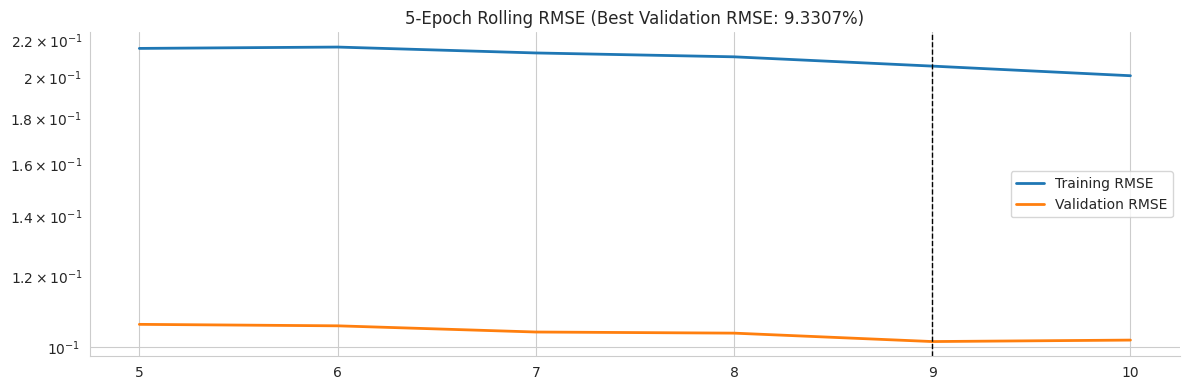

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(LSTM_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()
best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()

In [ ]:
train_rmse_scaled = np.sqrt(lstm_model.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(lstm_model.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE (scaled): {train_rmse_scaled:.4f} | Test RMSE (scaled): {test_rmse_scaled:.4f}')

Train RMSE (scaled): 0.0846 | Test RMSE (scaled): 0.1015


In [ ]:
train_predict_scaled = lstm_model.predict(X_train)
test_predict_scaled = lstm_model.predict(X_test)

train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f"Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Train IC: 0.9729 | Test IC: 0.9861


In [ ]:
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled).squeeze(), index=y_test.index))
# use inverse_transform to convert the scaled data back to its original scale.
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

In [ ]:
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
print(f"Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}")

Train RMSE: 45.25 | Test RMSE: 54.28


In [ ]:
stock_price['Train Predictions'] = train_predict
stock_price['Test Predictions'] = test_predict

to_be_merged = pd.concat([train_predict.to_frame('predictions').assign(data='Train'),
                   test_predict.to_frame('predictions').assign(data='Test')])

stock_price = pd.merge(stock_price, to_be_merged, how='inner', on = 'Date')
# remove the suffixes brought by pd.merge()
stock_price.columns = stock_price.columns.str.rstrip('_x').str.rstrip('_y')

In [ ]:
stock_price

,Adj Close,Train Predictions,Test Predictions,predictions,data
Date,,,,,
2020-03-30,370.959991,323.327972,NaN,323.327972,Train
2020-03-31,375.500000,329.638275,NaN,329.638275,Train
2020-04-01,364.079987,335.699799,NaN,335.699799,Train
2020-04-02,370.079987,339.051453,NaN,339.051453,Train
2020-04-03,361.760010,342.077332,NaN,342.077332,Train
...,...,...,...,...,...
2024-08-26,688.440002,NaN,593.703003,593.703003,Test
2024-08-27,695.719971,NaN,595.343323,595.343323,Test
2024-08-28,683.840027,NaN,596.804443,596.804443,Test


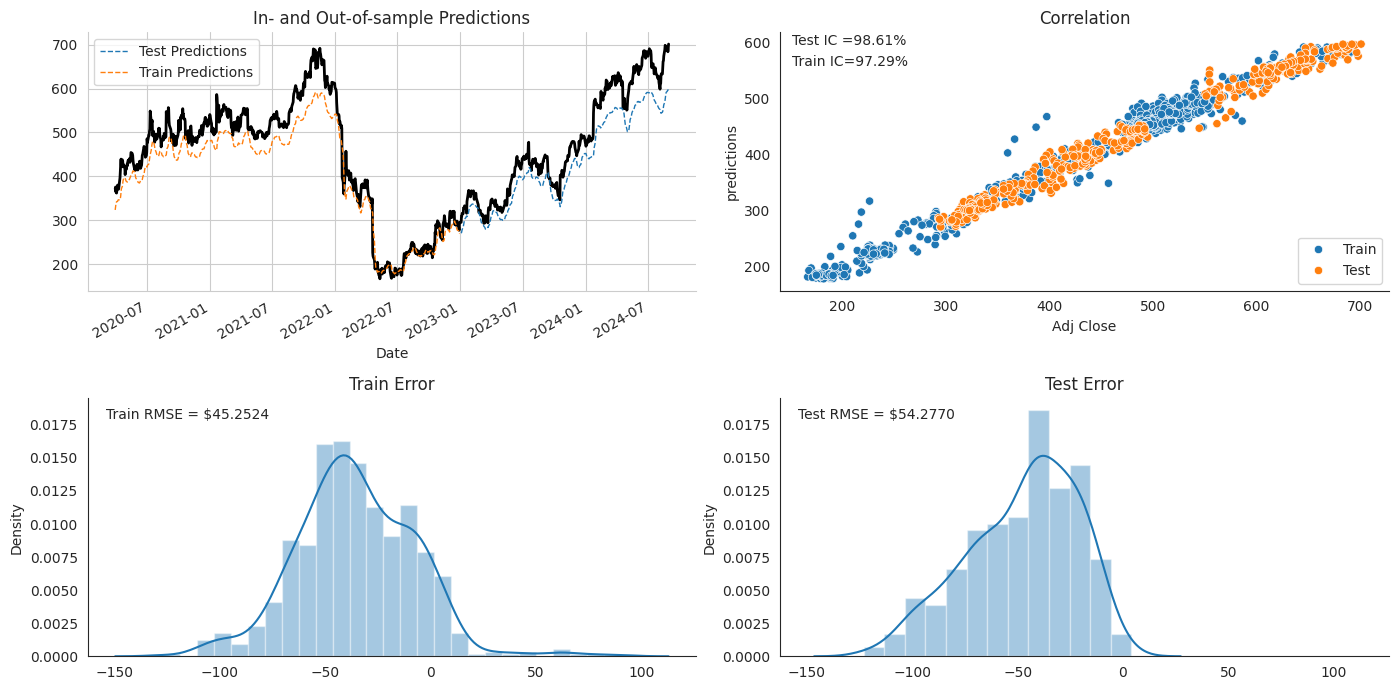

In [ ]:
fig=plt.figure(figsize=(14,7))
ax1 = plt.subplot(221)
stock_price.loc['2020':, price_type].plot(lw=2, ax=ax1, c='k')
stock_price.loc['2020':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')

with sns.axes_style("white"):
    ax3 = plt.subplot(222)
    sns.scatterplot(x = price_type, y = 'predictions', data = stock_price, hue = 'data', ax = ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')

    ax2 = plt.subplot(223)
    ax4 = plt.subplot((224), sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE = ${train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE = ${test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()